In [22]:
import math

import hist

import pylhe

import numpy as np

import matplotlib.pyplot as plt

from scipy.integrate import quad

In [25]:
class lheanalyze:
    def __init__(self, events, type):
        self.events = events
        self.length = len(events)
        self.type = type
        self.pevents = events.particles

    def momentum_array(self, event):
            px = event.px
            py = event.py
            pz = event.pz
            p = pylhe.awkward.ak.zip({"px":px, "py":py, "pz":pz})
            return p

    def dot_product(self, p1, p2): #particle array 1 and 2
            p1p = self.momentum_array(p1)
            p2p = self.momentum_array(p2)
            return (p1p["px"] * p2p["px"] + p1p["py"] * p2p["py"] + p1p["pz"] * p2p["pz"])

    def momentum_mag(self, particle):
            return np.sqrt(particle.px**2 + particle.py**2 + particle.pz**2)

    def calculate_cos(self, p1, p2):
            dot = self.dot_product(p1,p2)
            cos_theta = dot/ (self.momentum_mag(p1) * self.momentum_mag(p2))
            return cos_theta

    def calculate_yn(self):
        filtered_Nevents = self.pevents[self.pevents[:].id>100]
        Nevents = filtered_Nevents[pylhe.awkward.ak.num(filtered_Nevents) > 0]

        filtered_ANevents = self.pevents[self.pevents[:].id<-100]
        ANevents = filtered_ANevents[pylhe.awkward.ak.num(filtered_ANevents) > 0]
        
        def yn(pevents):
            m_T = np.sqrt(pevents.m**2 + pevents.vector.x**2 + pevents.vector.y**2)
            yn = np.arcsinh(pevents.vector.z / m_T)
            return yn
        
        return [yn(Nevents), yn(ANevents)]

    def rapidity_distribution(self, mode):
        s = 3000**2
        m_N = 1000
        m_W = 79.8
        g = 0.664
        u = 1
        def dsigma_dyn(yn, s, m_N, m_W):
            exp_2yn = np.exp(2 * yn)
            numerator = np.exp(4 * yn) * (s * exp_2yn - m_N**2)
            denominator = ((exp_2yn + 1)**2 * (s + m_W**2 - exp_2yn * (m_N**2 - m_W**2))**2)
            return numerator / denominator

        def dsigma_dcos(cos, s, m_N, m_W, g):
            numerator = g**4*(1 + cos)*(s - m_N**2)**2 * (s + m_N**2 + cos * (s - m_N**2))
            denominator = 64 * np.pi * s**2 * ((s - m_N**2) * (1 - cos) + 2 * m_W**2)**2
            return numerator / denominator
        sigma, _ = quad(dsigma_dcos, -1, 1, args=(s, m_N, m_W, g))
        pevents = self.pevents
        # s_N = pevents[:,-1]
        s_N_events = pevents[pevents[:,-2].id < 0]
        if self.type == "M":
            s_N = pevents[:,-1]
            s_N_cos = self.calculate_cos(self.pevents[:,1].vector, s_N.vector)
        else:
            s_N = s_N_events[:,-1]
            s_N_cos = self.calculate_cos(s_N_events[:,1].vector, s_N.vector)
        s_N_e = s_N.vector.e
        s_N_p = self.momentum_mag(s_N.vector)
        anti_s_N_events = pevents[pevents[:,-2].id > 0]
        anti_s_N = anti_s_N_events[:,-1]
        anti_s_N_cos = self.calculate_cos(anti_s_N_events[:,1].vector, anti_s_N.vector)
        anti_s_N_p = self.momentum_mag(anti_s_N.vector)
        anti_s_N_e = anti_s_N.vector.e
        yn_N_v2 = 1/2 * np.log((s_N_e + s_N_p*s_N_cos)/(s_N_e - s_N_p*s_N_cos))
        a_yn_N_v2 = 1/2 * np.log((anti_s_N_e + anti_s_N_p * anti_s_N_cos)/(anti_s_N_e - anti_s_N_p * anti_s_N_cos))
        def rapidity():
            if self.type == "M":
                plt.figure(figsize=(10, 6))
                plt.hist(yn_N_v2, bins=30, alpha=0.5, label='SN', color='red')
                plt.xlabel('y_N')
                plt.ylabel('Frequency')
                plt.title('Rapidity Distributions for Sterile Neutrinos(Majorana)')
                plt.legend()
                plt.show()
            else:
                plt.figure(figsize=(10, 6))
                plt.hist(yn_N_v2, bins=30, alpha=0.5, label='anti-nu partner', color='red')
                plt.hist(a_yn_N_v2, bins=30, alpha=0.5, label='nu partner', color='blue')
                plt.xlabel('y_N')
                plt.ylabel('Frequency')
                plt.title('Rapidity Distributions for Sterile Neutrinos and Anti-Sterile Neutrinos (Dirac)')
                plt.legend()
                plt.show()

        def normalized_rapidity():
            if self.type == 'D':
                n_dsigma_dyN = dsigma_dyn(yn_N_v2, s, m_N, m_W)
                negative_a_yn = -a_yn_N_v2
                anti_n_dsigma_dyN = dsigma_dyn(negative_a_yn, s, m_N, m_W)

                sorted_indices_sn = np.argsort(yn_N_v2)
                sorted_yn_sn = yn_N_v2[sorted_indices_sn]
                sorted_dsigma_dyn_sn = n_dsigma_dyN[sorted_indices_sn]

                sorted_indices_anti_sn = np.argsort(a_yn_N_v2)
                sorted_yn_anti_sn = a_yn_N_v2[sorted_indices_anti_sn]
                sorted_dsigma_dyn_anti_sn = anti_n_dsigma_dyN[sorted_indices_anti_sn]

                plt.figure(figsize=(10, 6))
                plt.plot(sorted_yn_sn, sorted_dsigma_dyn_sn, label='N', color='red', linestyle='-', marker='')
                plt.plot(sorted_yn_anti_sn, sorted_dsigma_dyn_anti_sn, label='anti-N', color='blue', linestyle='--', marker='')
                plt.yscale('log')
                plt.xlabel('y_N')
                plt.ylabel('Normalized dσ/dy_N')
                plt.title('Normalized Rapidity Distribution of Sterile Neutrinos (Dirac)')
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                n_dsigma_dyN = dsigma_dyn(yn_N_v2, s, m_N, m_W)
                negative_a_yn = -yn_N_v2
                anti_n_dsigma_dyN = dsigma_dyn(negative_a_yn, s, m_N, m_W)
                n_dsigma_dyN = n_dsigma_dyN + anti_n_dsigma_dyN


                sorted_indices_sn = np.argsort(yn_N_v2)
                sorted_yn_sn = yn_N_v2[sorted_indices_sn]
                sorted_dsigma_dyn_sn = n_dsigma_dyN[sorted_indices_sn]

                plt.figure(figsize=(10, 6))
                plt.plot(sorted_yn_sn, sorted_dsigma_dyn_sn, label='SN', color='red', linestyle='-', marker='')

                plt.yscale('log')
                plt.xlabel('y_N')
                plt.ylabel('Normalized dσ/dy_N')
                plt.title('Normalized Rapidity Distribution of Majorana-type Sterile Neutrinos')

                plt.legend()
                plt.grid(True)
                plt.show()
        def cos_differential_v1():
            plt.figure(figsize=(10, 6))
            differential_cross = 1/sigma *(dsigma_dcos(s_N_cos, 9000, 1, 80*10**-3, 0.664) + dsigma_dcos(-s_N_cos, 9000, 1, 80*10**-3, 0.664))
            if self.type == "D":
                anti_differential_cross = 1/sigma * (dsigma_dcos(anti_s_N_cos, 9000, 1, 80*10**-3, 0.664) + dsigma_dcos(-anti_s_N_cos, 9000, 1, 80*10**-3, 0.664))
            #anti_differential_cross = dsigma_dcos(-s_N_cos, 9000, 1, 80*10**-3)
            cos_values = np.linspace(-1, 1, 500)
            y_values = dsigma_dcos(cos_values, 9000, 1, 80*10**-3, 0.664)
            anti_y_values = dsigma_dcos(-cos_values, 9000, 1, 80*10**-3, 0.664)
            print(s_N_cos)

            sorted_cos_indices = np.argsort(s_N_cos)
            sorted_cos = s_N_cos[sorted_cos_indices]
            sorted_diff = differential_cross[sorted_cos_indices]
            if self.type == "D":
                sorted_a_cos_indices = np.argsort(anti_s_N_cos)
                sorted_a_cos = anti_s_N_cos[sorted_a_cos_indices]
                sorted_a_diff = anti_differential_cross[sorted_a_cos_indices]
            # anti_s_N_cos = -s_N_cos
            # sorted_a_cos_indices = np.argsort(anti_s_N_cos)
            # sorted_a_cos = anti_s_N_cos[sorted_a_cos_indices]
            # sorted_a_diff = anti_differential_cross[sorted_a_cos_indices]
            plt.plot(sorted_cos, sorted_diff, label='N', color='red')
            if self.type == "D":
                plt.plot(sorted_a_cos, sorted_a_diff, label='anti N', color='blue')#, linestyle='-')
            # plt.plot(cos_values, y_values, label='analytical function', color='red')
            # plt.plot(cos_values, anti_y_values, label='analytical function_2', color='blue')

            plt.yscale('log')
            plt.xlabel('cos(θ)')
            plt.ylabel('Differential Cross Section dσ/dcos(θ)')
            if self.type == "D":
                plt.title('Differential Cross Section vs cos(θ) for Dirac-type Sterile Neutrinos (in TeV)')
            else:
                plt.title('Differential Cross Section vs cos(θ) for Majorana-type Sterile Neutrinos (in TeV)')
            plt.grid(True)
            plt.legend()
            plt.show()
        def cos_differential_v2():
            if self.type == 'D':
                plt.figure(figsize=(10, 6))
                differential_cross1 = 1/sigma * dsigma_dcos(s_N_cos, 3000**2, 1000, 80, 0.664) #+ dsigma_dcos(-s_N_cos, 9000, 1, 80*10**-3)
                anti_differential_cross1 = 1/sigma * dsigma_dcos(anti_s_N_cos, 3000**2, 1000, 80, 0.664)
                differential_cross2 = 1/sigma * dsigma_dcos(-s_N_cos, 9000, 1, 80*10**-3, 0.664) #+ dsigma_dcos(-s_N_cos, 9000, 1, 80*10**-3)
                anti_differential_cross2 = 1/sigma * dsigma_dcos(-anti_s_N_cos, 9000, 1, 80*10**-3, 0.664)
                #anti_differential_cross = dsigma_dcos(-s_N_cos, 9000, 1, 80*10**-3)
                cos_values = np.linspace(-1, 1, 500)
                y_values = 1/sigma * dsigma_dcos(cos_values, 3000**2, 1000, 80, 0.664)
                anti_y_values = 1/sigma * dsigma_dcos(-cos_values, 3000**2, 1000, 80, 0.664)
                print(s_N_cos)

                sorted_cos_indices = np.argsort(s_N_cos)
                sorted_cos = s_N_cos[sorted_cos_indices]
                sorted_diff1 = differential_cross1[sorted_cos_indices]
                sorted_diff2 = differential_cross2[sorted_cos_indices]

                sorted_a_cos_indices = np.argsort(anti_s_N_cos)
                sorted_a_cos = anti_s_N_cos[sorted_a_cos_indices]
                sorted_a_diff1 = anti_differential_cross1[sorted_a_cos_indices]
                sorted_a_diff2 = anti_differential_cross2[sorted_a_cos_indices]

                # anti_s_N_cos = -s_N_cos
                # sorted_a_cos_indices = np.argsort(anti_s_N_cos)
                # sorted_a_cos = anti_s_N_cos[sorted_a_cos_indices]
                # sorted_a_diff = anti_differential_cross[sorted_a_cos_indices]

                # plt.scatter(sorted_cos, sorted_diff1, label='N', color='red')
                # plt.scatter(sorted_cos, sorted_diff2, label='N', color='red')
                # plt.scatter(sorted_a_cos, sorted_a_diff1, label='anti N', color='blue')
                # plt.scatter(sorted_a_cos, sorted_a_diff2, label='anti N', color='blue')#, linestyle='-')
                plt.plot(cos_values, y_values, label='analytical function (forward)', color='red')
                plt.plot(cos_values, anti_y_values, label='analytical function (backward)', color='blue')
                handles, labels = plt.gca().get_legend_handles_labels()
                unique_labels = dict(zip(labels, handles))
                plt.grid('True')
                plt.yscale('log')
                plt.xlabel('cos(θ)')
                plt.ylabel('Differential Cross Section dσ/dcos(θ)')
                if self.type == "D":
                    plt.title('Differential Cross Section vs cos(θ) for Dirac-type Sterile Neutrinos (in TeV)')
                else:
                    plt.title('Differential Cross Section vs cos(θ) for Majorana-type Sterile Neutrinos (in TeV)')
                plt.legend(unique_labels.values(), unique_labels.keys(), loc='lower center')
                plt.show()
        def cos_differential_v3():
            plt.figure(figsize=(10, 6))
            steps = 50
            if self.type == "D":
                 steps = int(steps / 2)
            l_factor = 484  / (self.length * 2/steps)
            # cos_hist1 = hist.Hist.new.Reg(steps, -1, 1).Int64()
            if self.type == "D":     
                plt.hist(anti_s_N_cos, bins=steps, weights=np.ones_like(anti_s_N_cos) * l_factor, color='blue', edgecolor='black', label='anti_N')
            # cos_hist1.fill(s_N_cos)
            # fig, ax = plt.subplots(figsize=(10, 6))
            # cos_hist1.plot1d(ax=ax, color='red', label='Sterile neutrino')
            plt.hist(s_N_cos, bins=steps, weights=np.ones_like(s_N_cos) * l_factor, color='red', edgecolor='black', label='N')
            # if self.type == "D":
                 
            #     cos_hist2.plot1d(ax=ax, color='blue', label='Anti Sterile neutrino')

            differential_cross = 1/sigma *(dsigma_dcos(s_N_cos, 9000000, 1000, 80, 0.664) + dsigma_dcos(-s_N_cos, 9000000, 1000, 80, 0.664))
            if self.type == "D":
                anti_differential_cross =  1/sigma * (dsigma_dcos(anti_s_N_cos, 9000000, 1000, 80, 0.664) + dsigma_dcos(-anti_s_N_cos, 9000000, 1000, 80, 0.664))
            #anti_differential_cross = dsigma_dcos(-s_N_cos, 9000, 1, 80*10**-3)
            cos_values = np.linspace(-1, 1, 500)
            y_values = dsigma_dcos(cos_values, 9000, 1, 80*10**-3, 0.664)
            anti_y_values = dsigma_dcos(-cos_values, 9000, 1, 80*10**-3, 0.664)


            sorted_cos_indices = np.argsort(s_N_cos)
            sorted_cos = s_N_cos[sorted_cos_indices]
            sorted_diff = differential_cross[sorted_cos_indices]
            if self.type == "D":
                sorted_a_cos_indices = np.argsort(anti_s_N_cos)
                sorted_a_cos = anti_s_N_cos[sorted_a_cos_indices]
                sorted_a_diff = anti_differential_cross[sorted_a_cos_indices]
            # anti_s_N_cos = -s_N_cos
            # sorted_a_cos_indices = np.argsort(anti_s_N_cos)
            # sorted_a_cos = anti_s_N_cos[sorted_a_cos_indices]
            # sorted_a_diff = anti_differential_cross[sorted_a_cos_indices]
            plt.plot(sorted_cos, sorted_diff, label='N', color='red')
            if self.type == "D":
                plt.plot(sorted_a_cos, sorted_a_diff, label='anti N', color='blue')#, linestyle='-')
            # plt.plot(cos_values, y_values, label='analytical function', color='red')
            # plt.plot(cos_values, anti_y_values, label='analytical function_2', color='blue')

            plt.yscale('log')
            plt.xlabel('cos(θ)')
            plt.ylabel('Differential Cross Section dσ/dcos(θ)')
            if self.type == "D":
                plt.title('Differential Cross Section vs cos(θ) for Dirac-type Sterile Neutrinos (in TeV)')
            else:
                plt.title('Differential Cross Section vs cos(θ) for Majorana-type Sterile Neutrinos (in TeV)')
            plt.grid(True)
            plt.legend()
            plt.show()
        def test():
            u = 484/sigma
            plt.figure(figsize=(10, 6))
            steps = 50
            rsigma = 484
            if self.type == "D":
                 steps = int(steps / 2)
            l_factor = 484  / (self.length * 2/steps)
            if self.type == "D":     
                plt.hist(anti_s_N_cos, bins=steps, weights=np.ones_like(anti_s_N_cos) * l_factor, color='blue', edgecolor='black', label='anti_N')
            plt.hist(s_N_cos, bins=steps, weights=np.ones_like(s_N_cos) * l_factor, color='red', edgecolor='black', label='N')
            differential_cross = u * 1/rsigma *(dsigma_dcos(s_N_cos, 9000000, 1000, 80, 0.664) + dsigma_dcos(-s_N_cos, 9000000, 1000, 80, 0.664))
            if self.type == "D":
                anti_differential_cross = u * 1/rsigma * (dsigma_dcos(anti_s_N_cos, 9000000, 1000, 80, 0.664) + dsigma_dcos(-anti_s_N_cos, 9000000, 1000, 80, 0.664))
            #anti_differential_cross = dsigma_dcos(-s_N_cos, 9000, 1, 80*10**-3)
            cos_values = np.linspace(-1, 1, 500)
            y_values = dsigma_dcos(cos_values, 9000, 1, 80*10**-3, 0.664)
            anti_y_values = dsigma_dcos(-cos_values, 9000, 1, 80*10**-3, 0.664)


            sorted_cos_indices = np.argsort(s_N_cos)
            sorted_cos = s_N_cos[sorted_cos_indices]
            sorted_diff = differential_cross[sorted_cos_indices]
            if self.type == "D":
                sorted_a_cos_indices = np.argsort(anti_s_N_cos)
                sorted_a_cos = anti_s_N_cos[sorted_a_cos_indices]
                sorted_a_diff = anti_differential_cross[sorted_a_cos_indices]
            # anti_s_N_cos = -s_N_cos
            # sorted_a_cos_indices = np.argsort(anti_s_N_cos)
            # sorted_a_cos = anti_s_N_cos[sorted_a_cos_indices]
            # sorted_a_diff = anti_differential_cross[sorted_a_cos_indices]
            plt.plot(sorted_cos, sorted_diff, label='N', color='red')
            if self.type == "D":
                plt.plot(sorted_a_cos, sorted_a_diff, label='anti N', color='blue')#, linestyle='-')
            # plt.plot(cos_values, y_values, label='analytical function', color='red')
            # plt.plot(cos_values, anti_y_values, label='analytical function_2', color='blue')

            plt.yscale('log')
            plt.xlabel('cos(θ)')
            plt.ylabel('Differential Cross Section dσ/dcos(θ)')
            if self.type == "D":
                plt.title('Differential Cross Section vs cos(θ) for Dirac-type Sterile Neutrinos (in TeV)')
            else:
                plt.title('Differential Cross Section vs cos(θ) for Majorana-type Sterile Neutrinos (in TeV)')
            plt.grid(True)
            plt.legend()
            plt.show()
            
        if mode == "A":
             rapidity()
        elif mode == "B":
             normalized_rapidity()
        elif mode == "C":
             cos_differential_v1()
        elif mode == "D":
             cos_differential_v2()
        elif mode == "E":
             cos_differential_v3()
        elif mode == "T":
             test()
        print(sigma)

    def differential_cross_section(self,steps,r_sigma):
        s = 3000**2
        m_N = 1000
        m_W = 79.8
        g = 0.664
        u = 1
        def dsigma_dcos(cos, s, m_N, m_W, g):
            numerator = g**4*(1 + cos)*(s - m_N**2)**2 * (s + m_N**2 + cos * (s - m_N**2))
            denominator = 64 * np.pi * s**2 * ((s - m_N**2) * (1 - cos) + 2 * m_W**2)**2
            return numerator / denominator
        sigma, _ = quad(dsigma_dcos, -1, 1, args=(s, m_N, m_W, g))
        u =  r_sigma * 2.568  * 10**-9 / sigma
        sigma = r_sigma * 2.568  * 10**-9
        pevents = self.pevents
        s_N_events = pevents[pevents[:,-2].id < 0]
        if self.type == "M":
            s_N = pevents[:,-1]
            s_N_cos = self.calculate_cos(self.pevents[:,1].vector, s_N.vector)
        else:
            s_N = s_N_events[:,-1]
            s_N_cos = self.calculate_cos(s_N_events[:,1].vector, s_N.vector)
        anti_s_N_events = pevents[pevents[:,-2].id > 0]
        anti_s_N = anti_s_N_events[:,-1]
        anti_s_N_cos = self.calculate_cos(anti_s_N_events[:,1].vector, anti_s_N.vector)

        cos_values = np.linspace(-1, 1, 500)
        y_values = u * (dsigma_dcos(cos_values, s, m_N, m_W, g) + dsigma_dcos(-cos_values, s, m_N, m_W, g))


        plt.figure(figsize=(10, 6))
        # steps = 50
        l_factor = sigma / (self.length * 2/steps)
        print(l_factor)
        if self.type == "D":
            steps = int(steps/2)
            plt.hist(anti_s_N_cos, bins=int(steps), weights=np.ones_like(anti_s_N_cos) * l_factor/sigma, color='blue', edgecolor='black', label='anti_N') 
        plt.hist(s_N_cos, bins=steps, color='red', weights=np.ones_like(s_N_cos) * l_factor/sigma, edgecolor='black', label='N') 
        plt.plot(cos_values, y_values/sigma, label='analytical function', color='black')
        plt.xlabel('cos(theta)')
        plt.ylabel('frequency')
        plt.grid('True')
        plt.legend()
        plt.yscale('log')
    
    def separate_differential_cross_section(self,steps,r_sigma,region):
        s = 3000**2
        m_N = 1000
        m_W = 79.8
        g = 0.664
        u = 1
        def dsigma_dcos(cos, s, m_N, m_W, g):
            numerator = g**4*(1 + cos)*(s - m_N**2)**2 * (s + m_N**2 + cos * (s - m_N**2))
            denominator = 64 * np.pi * s**2 * ((s - m_N**2) * (1 - cos) + 2 * m_W**2)**2
            return numerator / denominator
        sigma, _ = quad(dsigma_dcos, -1, 1, args=(s, m_N, m_W, g))
        u =  r_sigma * 2.568  * 10**-9 / sigma
        sigma = r_sigma * 2.568  * 10**-9
        print("sigma=",484 * 2.568  * 10**-9)
        pevents = self.pevents
        s_N_events = pevents[pevents[:,-2].id < 0]
        if self.type == "M":
            s_N = pevents[:,-1]
            s_N_cos = self.calculate_cos(self.pevents[:,1].vector, s_N.vector)
        else:
            s_N = s_N_events[:,-1]
            s_N_cos = self.calculate_cos(s_N_events[:,1].vector, s_N.vector)
        anti_s_N_events = pevents[pevents[:,-2].id > 0]
        anti_s_N = anti_s_N_events[:,-1]
        anti_s_N_cos = self.calculate_cos(anti_s_N_events[:,1].vector, anti_s_N.vector)

        cos_values = np.linspace(-1, 1, 500)
        if region == 'f':
            y_values = u * (dsigma_dcos(cos_values, s, m_N, m_W, g))#+ dsigma_dcos(-cos_values, s, m_N, m_W, g))
        else:
            y_values = u * (dsigma_dcos(-cos_values, s, m_N, m_W, g))#+ dsigma_dcos(cos_values, s, m_N, m_W, g))

        plt.figure(figsize=(10, 6))
        # steps = 50
        l_factor = sigma / (self.length * 2/steps)
        if region == 'b':
            plt.hist(anti_s_N_cos, bins=steps, weights=np.ones_like(anti_s_N_cos) * l_factor/sigma, color='blue', edgecolor='black', label='anti_N') 
        else:
            plt.hist(s_N_cos, bins=steps, color='red', weights=np.ones_like(s_N_cos) * l_factor/sigma, edgecolor='black', label='N') 
        plt.plot(cos_values, y_values/sigma, label='analytical function', color='black')
        plt.xlabel('cos(theta)')
        plt.ylabel('frequency')
        plt.grid('True')
        plt.legend()
        plt.yscale('log')

    def differential_cross_section_yn(self,steps,r_sigma):
        s = 3000**2
        m_N = 1000
        m_W = 79.8
        g = 0.664
        u = 1
        def dsigma_dcos(cos, s, m_N, m_W, g):
            numerator = g**4*(1 + cos)*(s - m_N**2)**2 * (s + m_N**2 + cos * (s - m_N**2))
            denominator = 64 * np.pi * s**2 * ((s - m_N**2) * (1 - cos) + 2 * m_W**2)**2
            return numerator / denominator
        
        def dsigma_dyn(yn, s, m_N, m_W, g):
            numerator = g**4 *(s + m_N**2)**2*np.exp(4*yn)*(s*np.exp(2*yn)-m_N**2)
            denominator = 16 * np.pi*s**2*(s+m_W**2+(m_W**2-m_N**2)*np.exp(2*yn))**2*(np.exp(2*yn)+1)**2
            return numerator / denominator
        sigma, _ = quad(dsigma_dcos, -1, 1, args=(s, m_N, m_W, g))
        u =  r_sigma * 2.568  * 10**-9 / sigma
        sigma = r_sigma * 2.568  * 10**-9
        yn = self.calculate_yn()
        print(yn)
        if self.type == "M":
            N_yn = yn[0]
        else:
            N_yn = yn[0]
            AN_yn = yn[1]

        yn_values = np.linspace(-1.1, 1.1, 500)
        y_values = u * (dsigma_dyn(yn_values, s, m_N, m_W, g) + dsigma_dyn(-yn_values, s, m_N, m_W, g))

        print(N_yn)
        plt.figure(figsize=(10, 6))
        # steps = 50
        l_factor = sigma / (self.length * 2/steps)
        print(l_factor)
        if self.type == "D":
            steps = int(steps/2)
            plt.hist(AN_yn, bins=int(steps), weights=np.ones_like(AN_yn) * l_factor/sigma, color='blue', edgecolor='black', label='anti_N') 
        plt.hist(N_yn, bins=steps, color='red', weights=np.ones_like(N_yn) * l_factor/sigma, edgecolor='black', label='N') 
        plt.plot(yn_values, y_values/sigma, label='analytical function', color='black')
        plt.xlabel('cos(theta)')
        plt.ylabel('frequency')
        plt.grid('True')
        plt.legend()
        plt.yscale('log')
    

1.1556000000000002e-09
[<Array [[-1.1], [-1.1], ..., [-1.09], [-1.09]] type='50111 * var * float64'>, <Array [[1.09], [1.09], [1.1], ..., [1.1], [1.1]] type='49889 * var * float64'>]
[[-1.1], [-1.1], [-1.09], [-1.1], ..., [-1.09], [-1.09], [-1.09], [-1.09]]
1.1556000000000002e-09


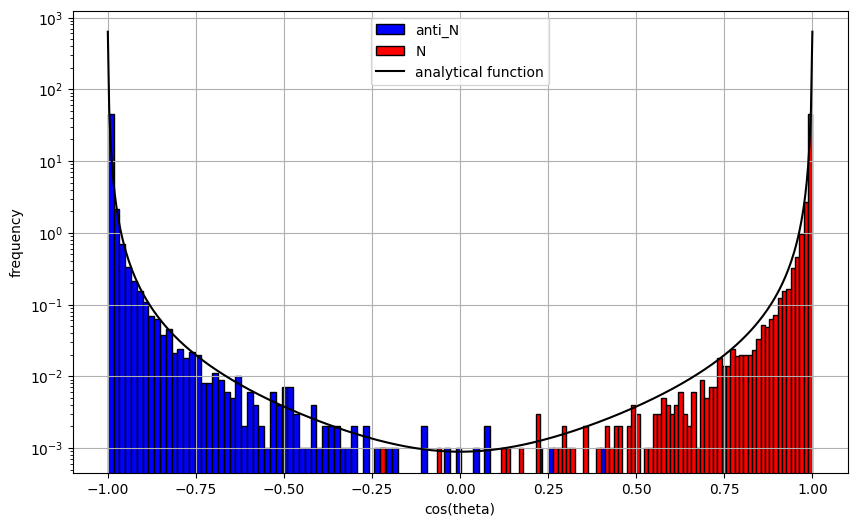

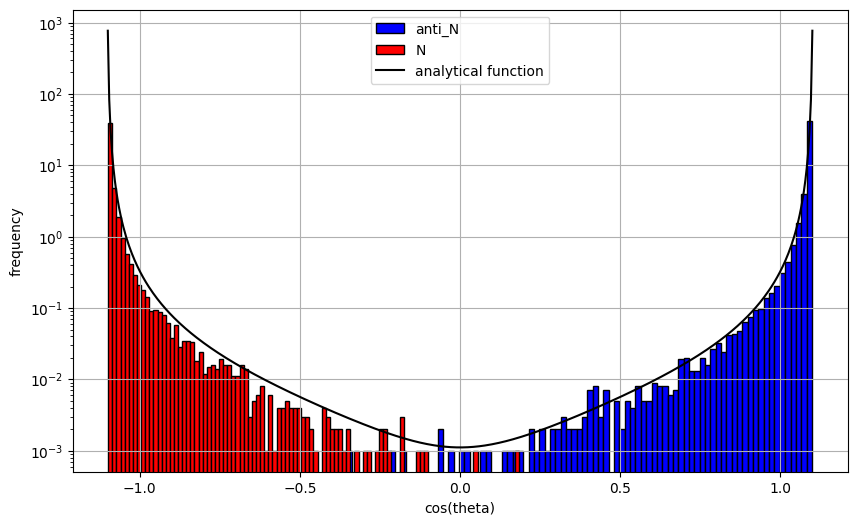

In [26]:
# d1_lhe = '/home/jwdiao/eEvN_v2/Events/run_01/unweighted_events.lhe'
# d1_events = pylhe.to_awkward(pylhe.read_lhe_with_attributes(d1_lhe))
# d1 = lheanalyze(d1_events, 'D')
# d1.rapidity_distribution('D')
# d1.differential_cross_section(50,450)
# d1.separate_differential_cross_section(50,450,'b')
# m1_lhe = '/home/jwdiao/eEvN_m_v3/Events/run_01/unweighted_events.lhe'
# m1_events = pylhe.to_awkward(pylhe.read_lhe_with_attributes(m1_lhe))
# m1 = lheanalyze(m1_events, 'M')
# # m1.rapidity_distribution('E')
# m1.differential_cross_section(50,450)

d2_lhe = '/home/jwdiao/eEvN_v5/Events/run_01/unweighted_events.lhe'
d1_events = pylhe.to_awkward(pylhe.read_lhe_with_attributes(d2_lhe))
d1 = lheanalyze(d1_events, 'D')
#d1.rapidity_distribution('D')
d1.differential_cross_section(200,450)
# d1.separate_differential_cross_section(200,225,'f')
# d1.separate_differential_cross_section(200,225,'b')
d1.differential_cross_section_yn(200,450)